## Temperature forecasting for different cities in the world

## Introduction
For this project you are asked to analyze three datasets, called respectively:
1. pollution_us_2000_2016.csv
2. greenhouse_gas_inventory_data_data.csv
3. GlobalLandTemperaturesByCity.csv

You are asked to extract from dataset 2 only the US countries (for which we have info in the other datasets) and to perform the following tasks:
- to measure how pollution and temperature create cluster tracing the high populated cities in the world
- to analyze the correlation between pollution data and temperature change.
- to predict the yearly temperature change of a given city over a given time period, using the <b>ARIMA model</b> for <b>time series forecasting</b>, that is a model for time series forecasting integrating AR models with Moving Average.
- (OPTIONAL) rank the 5 cities that will have a highest temperature change in US


### TASK1 :Cluster Analysis
You use K-means or DBSCAN to perform the cluster analysis, and create a new dataset where the cities are associated to the different identified clusters

### TASK 2: Correlation Analysis

You measure the correlation between:
- temperature and latitude
- temperature and pollution
- temperature change (difference between the average temperature measured over the last 3 years and the previous temperature) and pollution


### TASK 3: Predicting the Temperature of a Given City across a Specified Time Period
After reading the data in the temperature data set, for each city cluster, before applying the ARIMA model you perform the following steps:

- EDA
- data cleaning and preprocessing (Converting the 'dt' (date) column to DateTime format, removing NaN)
- feature selection
- make the time-series stationary
- check for stationarity : Calculating the Augmented Dickey-Fuller Test statistic 
- identify the (p, q) order of the ARIMA model using ACF partial autocorrelation plot

Then:

-fit the ARIMA model using the calculated p, q values.
-calculate the MSE with respect to the true temp. measurements to estimate the performance of the model


NOTE: ARIMA models need the data to be stationary i.e. the data must not exhibit trend and/or seasonality. To identify and remove trend and seasonality, we can use
- seasonal decomposition
- differencing

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import ipywidgets as widgets
import seaborn as sns
from nfunctions import * 
from scipy.stats import pearsonr, linregress
%load_ext autoreload
%autoreload 2

## SECTION 1: Cluster Analysis

In [2]:
pollution = pd.read_csv('Project_3/data/data-project3/pollution_us_2000_2016.csv')
greenhouse = pd.read_csv('Project_3/data/data-project3/greenhouse_gas_inventory_data_data(1).csv')
temperature = pd.read_csv('Project_3/data/data-project3/GlobalLandTemperaturesByCity.csv')

In [3]:
us_greenhouse = greenhouse[greenhouse['country_or_area'] == 'United States of America']

In [4]:
us_pollution = pollution[pollution['State'].notnull() & pollution['City'].notnull()]
us_pollution['City'] = us_pollution['City'].str.title().str.strip()
us_pollution['State'] = us_pollution['State'].str.title().str.strip()

In [5]:
us_temperature = temperature[temperature['Country'] == 'United States']
us_temperature['City'] = us_temperature['City'].str.title().str.strip()

/tmp/ipykernel_8115/2883389352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temperature['City'] = us_temperature['City'].str.title().str.strip()


In [6]:
common_cities = set(us_pollution['City']).intersection(set(us_temperature['City']))
us_pollution = us_pollution[us_pollution['City'].isin(common_cities)]
us_temperature = us_temperature[us_temperature['City'].isin(common_cities)]

In [7]:
# Aggregate pollution by city and year
pollution['Date Local'] = pd.to_datetime(pollution['Date Local'])
pollution['Year'] = pollution['Date Local'].dt.year
pollution_agg = pollution.groupby(['City', 'Year'])[['NO2 Mean', 'CO Mean', 'SO2 Mean']].mean().reset_index()

# Process temperature data
temperature['dt'] = pd.to_datetime(temperature['dt'])
temperature['Year'] = temperature['dt'].dt.year
temp_agg = temperature.groupby(['City', 'Year'])['AverageTemperature'].mean().reset_index()

# Merge pollution + temperature on city and year
combined_df = pd.merge(pollution_agg, temp_agg, on=['City', 'Year'], how='inner')

In [8]:
features = combined_df[['NO2 Mean', 'CO Mean', 'SO2 Mean', 'AverageTemperature']]
scaled = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
combined_df['Cluster'] = kmeans.fit_predict(scaled)

In [9]:
correlation_matrix = combined_df[['NO2 Mean', 'CO Mean', 'SO2 Mean', 'AverageTemperature']].corr()
print(correlation_matrix['AverageTemperature'])

NO2 Mean             -0.018964
CO Mean               0.110304
SO2 Mean             -0.341506
AverageTemperature    1.000000
Name: AverageTemperature, dtype: float64


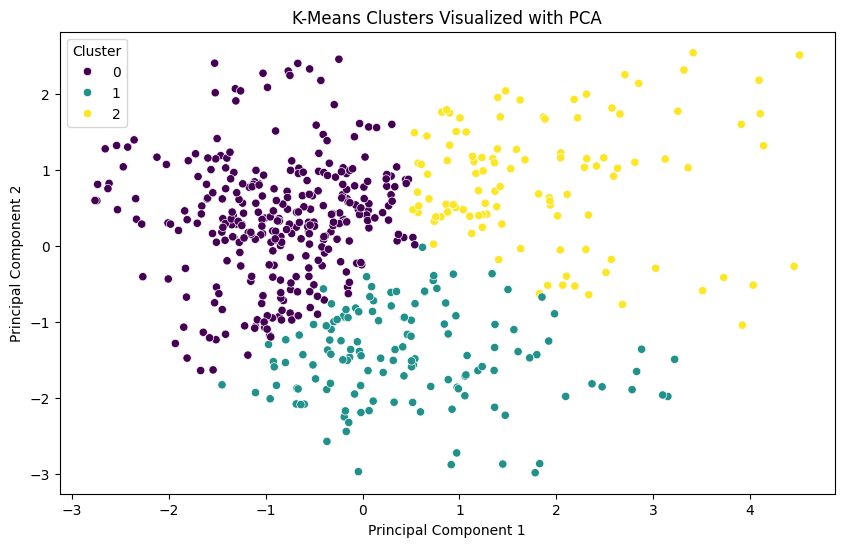

          City  Cluster
0  Albuquerque        0
1   Alexandria        0
2       Athens        0
3       Austin        0
4  Bakersfield        2


In [10]:
# Scale features (pollution and temperature)
features = combined_df[['NO2 Mean', 'CO Mean', 'SO2 Mean', 'AverageTemperature']]
scaled = StandardScaler().fit_transform(features)

# K-Means clustering with 3 clusters (adjust n_clusters if needed)
kmeans = KMeans(n_clusters=3, random_state=42)
combined_df['Cluster'] = kmeans.fit_predict(scaled)

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled)
combined_df['PC1'] = pca_features[:, 0]
combined_df['PC2'] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=combined_df, palette='viridis')
plt.title("K-Means Clusters Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Optionally, produce a dataset mapping each city to its cluster.
# For a single city-level assignment, you might take the mode of the clusters for each city:
city_cluster = combined_df.groupby('City')['Cluster'].agg(lambda x: x.value_counts().index[0]).reset_index()
print(city_cluster.head())


Pearson r (Avg Temp vs. Latitude): -0.91


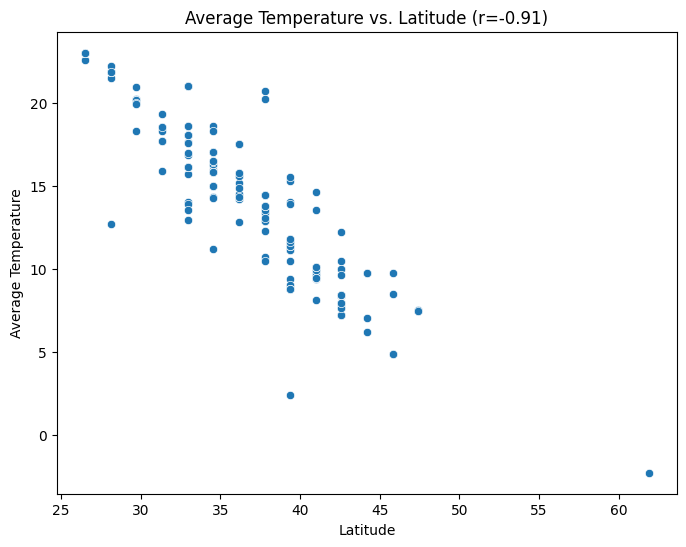

In [11]:
# Extract unique city latitude and convert to numeric
def convert_lat(lat_str):
    if isinstance(lat_str, str):
        if 'N' in lat_str:
            return float(lat_str.replace('N',''))
        elif 'S' in lat_str:
            return -float(lat_str.replace('S',''))
    return lat_str

# Use the US temperature data (before aggregation) to get coordinates
us_temperature_coords = temperature[temperature['Country'] == 'United States'][['City', 'Latitude', 'Longitude']].drop_duplicates()
us_temperature_coords['Latitude'] = us_temperature_coords['Latitude'].apply(convert_lat)

# Get city-level average temperature (aggregated over years)
city_temp_avg = temp_agg.groupby('City')['AverageTemperature'].mean().reset_index()

# Merge to obtain temperature with latitude
city_temp_lat = pd.merge(city_temp_avg, us_temperature_coords, on='City', how='inner')

# Compute Pearson correlation between average temperature and latitude
corr_lat, p_val_lat = pearsonr(city_temp_lat['AverageTemperature'], city_temp_lat['Latitude'])
print(f"Pearson r (Avg Temp vs. Latitude): {corr_lat:.2f}")

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Latitude', y='AverageTemperature', data=city_temp_lat)
plt.title(f"Average Temperature vs. Latitude (r={corr_lat:.2f})")
plt.xlabel("Latitude")
plt.ylabel("Average Temperature")
plt.show()


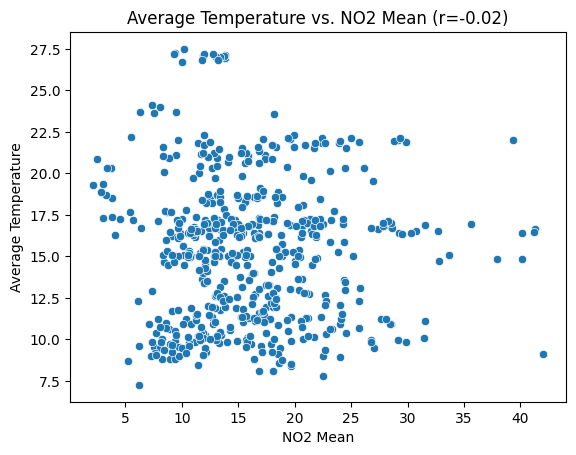

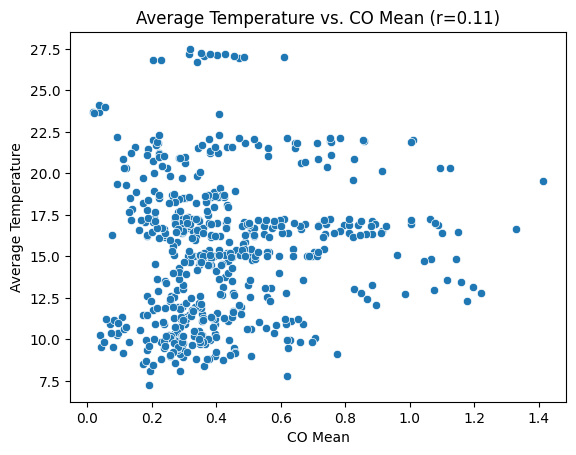

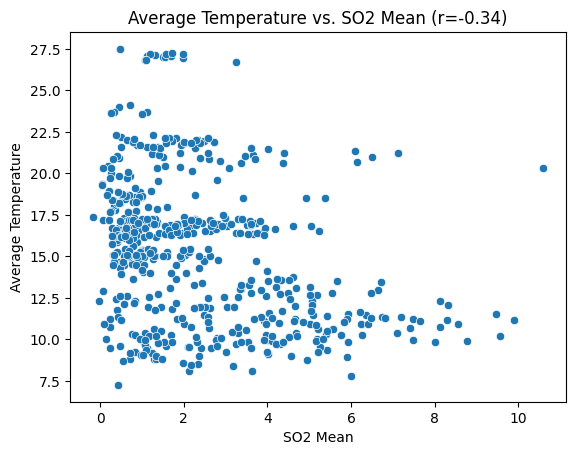

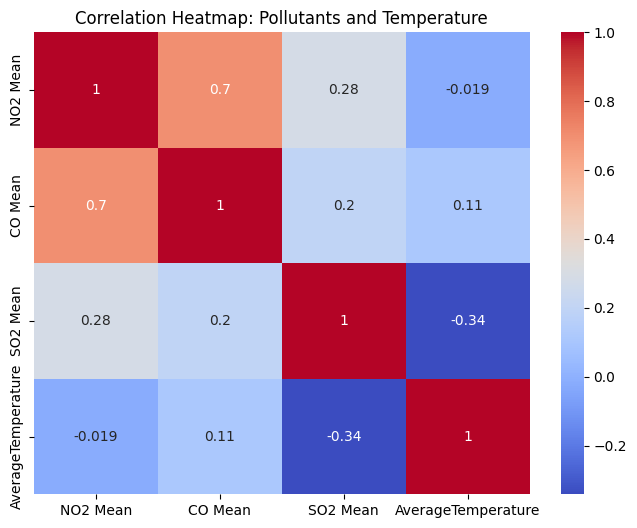

In [12]:
# Scatter plots and Pearson correlations for each pollutant
pollutants = ['NO2 Mean', 'CO Mean', 'SO2 Mean']
for pollutant in pollutants:
    plt.figure()
    sns.scatterplot(x=combined_df[pollutant], y=combined_df['AverageTemperature'])
    corr, p_val = pearsonr(combined_df[pollutant], combined_df['AverageTemperature'])
    plt.title(f"Average Temperature vs. {pollutant} (r={corr:.2f})")
    plt.xlabel(pollutant)
    plt.ylabel("Average Temperature")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(combined_df[['NO2 Mean', 'CO Mean', 'SO2 Mean', 'AverageTemperature']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Pollutants and Temperature")
plt.show()

/tmp/ipykernel_8115/911894124.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_change = temp_agg.groupby('City').apply(compute_temp_change).reset_index(name='TempChange')


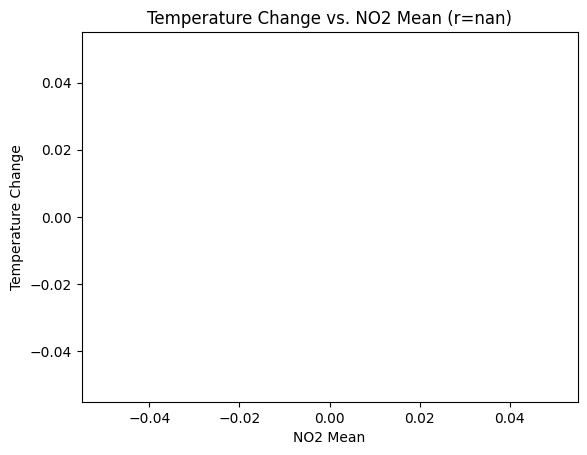

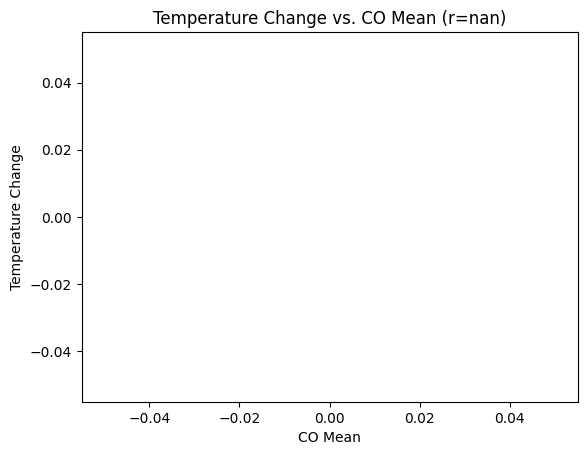

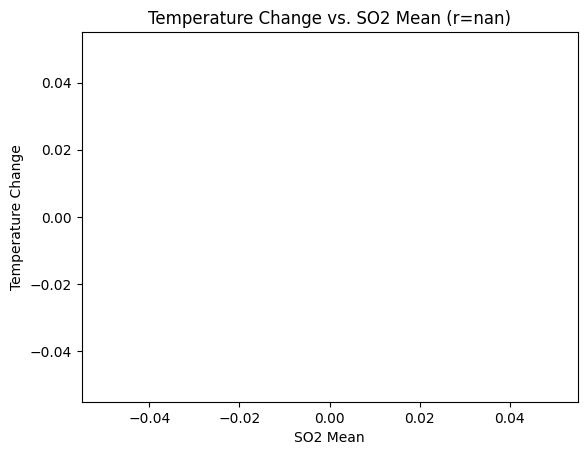

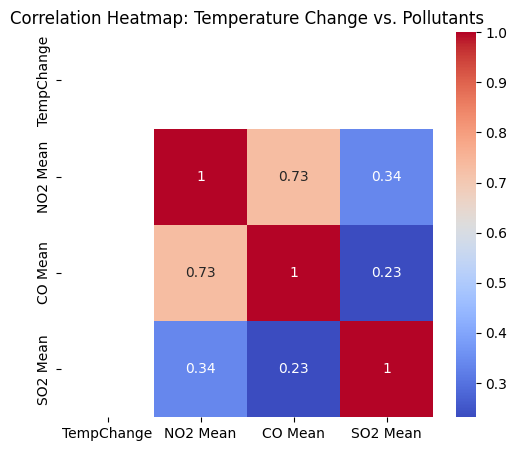

In [13]:
# Define function to compute temperature change for a given city
def compute_temp_change(df):
    last3 = df[df['Year'] >= 2014]['AverageTemperature'].mean()
    prior = df[df['Year'] < 2014]['AverageTemperature'].mean()
    return last3 - prior

# Compute temperature change per city using the aggregated temperature data
temp_change = temp_agg.groupby('City').apply(compute_temp_change).reset_index(name='TempChange')

# Compute average pollution levels per city (aggregating over all years)
pollution_city = pollution_agg.groupby('City')[['NO2 Mean', 'CO Mean', 'SO2 Mean']].mean().reset_index()

# Merge temperature change with pollution levels
temp_pollution = pd.merge(temp_change, pollution_city, on='City', how='inner')

# Scatter plots and correlations for temperature change vs. each pollutant
for pollutant in pollutants:
    plt.figure()
    sns.scatterplot(x=pollutant, y='TempChange', data=temp_pollution)
    corr_val, p_val_val = pearsonr(temp_pollution[pollutant], temp_pollution['TempChange'])
    plt.title(f"Temperature Change vs. {pollutant} (r={corr_val:.2f})")
    plt.xlabel(pollutant)
    plt.ylabel("Temperature Change")
    plt.show()

# Heatmap for temperature change and pollutants
plt.figure(figsize=(6, 5))
corr_temp_pollution = temp_pollution[['TempChange', 'NO2 Mean', 'CO Mean', 'SO2 Mean']].corr()
sns.heatmap(corr_temp_pollution, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Temperature Change vs. Pollutants")
plt.show()

In [14]:
import itertools
import warnings
warnings.filterwarnings("ignore")

cities = temp_agg['City'].unique()
results = []

for city in cities:
    city_temp_series = temp_agg[temp_agg['City'] == city].sort_values('Year')
    # Set the Year as index and get the temperature series
    ts = city_temp_series.set_index('Year')['AverageTemperature']
    
    # Skip cities with too few observations
    if len(ts) < 5:
        continue
    
    best_aic = np.inf
    best_order = None
    best_model = None
    
    # Grid search for ARIMA orders (p, d=0, q) with small ranges
    for p in range(3):
        for q in range(3):
            try:
                model = ARIMA(ts, order=(p, 0, q)).fit(method='mle', disp=0)
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, 0, q)
                    best_model = model
            except:
                continue
                
    # In-sample one-step predictions and MAE calculation
    ts_pred = best_model.predict(start=ts.index[0], end=ts.index[-1])
    mae = np.mean(np.abs(ts - ts_pred))
    
    # Forecast next 10 years
    forecast_steps = 10
    forecast = best_model.forecast(steps=forecast_steps)[0]
    forecast_years = np.arange(ts.index[-1] + 1, ts.index[-1] + forecast_steps + 1)
    
    # Compute forecasted temperature increase (difference between forecasted value at horizon 10 and the last observed value)
    forecast_increase = forecast[-1] - ts.iloc[-1]
    
    results.append({
         'City': city,
         'Best Order': best_order,
         'AIC': best_aic,
         'MAE': mae,
         'Forecast Increase': forecast_increase,
         'Forecast Years': list(forecast_years),
         'Forecast': list(forecast),
         'Historical': ts.tolist(),
         'Historical Years': list(ts.index)
    })

results_df = pd.DataFrame(results)
print(results_df.head())


AttributeError: 'NoneType' object has no attribute 'predict'

In [15]:
# Rank the top 5 cities with highest forecasted increase
top5 = results_df.sort_values(by='Forecast Increase', ascending=False).head(5)
print("Top 5 Cities with Highest Forecasted Temperature Increase:")
print(top5[['City', 'Forecast Increase']])

# Bar chart
plt.figure(figsize=(10,6))
sns.barplot(x='City', y='Forecast Increase', data=top5, palette='viridis')
plt.title("Top 5 Cities with Highest Forecasted Temperature Increase")
plt.xlabel("City")
plt.ylabel("Forecasted Increase (°C)")
plt.show()


NameError: name 'results_df' is not defined

In [16]:
# Select an example city from the top 5 (e.g., the first one)
example_city = top5.iloc[0]['City']
example_result = results_df[results_df['City'] == example_city].iloc[0]

plt.figure(figsize=(10,6))
plt.plot(example_result['Historical Years'], example_result['Historical'], marker='o', label='Historical')
plt.plot(example_result['Forecast Years'], example_result['Forecast'], marker='x', linestyle='--', label='Forecast')
plt.title(f"Temperature Forecast for {example_city}")
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.legend()
plt.show()


NameError: name 'top5' is not defined

In [2]:
import random
from datetime import datetime, timedelta

# List of U.S. states
states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia",
    "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
    "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
    "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina",
    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

# Function to generate random dates within a range
def random_date(start, end):
    delta = end - start
    random_days = random.randint(0, delta.days)
    return start + timedelta(days=random_days)

# Define date range
start_date = datetime(2020, 1, 1)
end_date = datetime(2025, 1, 1)

# Generate data
num_samples = 1000
data = {
    "City": [random.choice(states) for _ in range(num_samples)],
    "Latitude": [round(random.uniform(24.396308, 49.384358), 6) for _ in range(num_samples)],  # USA Latitude range
    "Longitude": [round(random.uniform(-125.000000, -66.934570), 6) for _ in range(num_samples)],  # USA Longitude range
    "Pollution": [random.randint(10, 500) for _ in range(num_samples)],  # Random pollution level
    "CO2": [random.randint(300, 500) for _ in range(num_samples)],  # CO2 levels in ppm
    "Temp": [round(random.uniform(10.396308, 40.384358), 6) for _ in range(num_samples)],
    "Date": [random_date(start_date, end_date).strftime('%Y-%m-%d') for _ in range(num_samples)],
}

# Create DataFrame
df = pd.DataFrame(data)

# Display first few rows
print(df.head())

           City   Latitude   Longitude  Pollution  CO2       Temp        Date
0         Maine  43.314346  -99.721880        486  394  40.295507  2021-04-25
1          Iowa  42.204900 -121.379474        149  440  33.851898  2023-03-15
2      Maryland  32.666875 -117.658404        289  477  28.845331  2022-11-27
3  North Dakota  30.195670 -120.934497        431  499  18.999373  2023-02-10
4      Maryland  45.768333  -71.476385        153  369  21.693959  2021-12-14


In [3]:
# 1. Data Preprocessing
# ---------------------
# Convert the Date column to datetime format if not already done
df['Date'] = pd.to_datetime(df['Date'])

# Select the numerical features to scale
num_features = ['Latitude', 'Longitude', 'Pollution', 'CO2', 'Temp']

# Scale the numerical features for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[num_features])

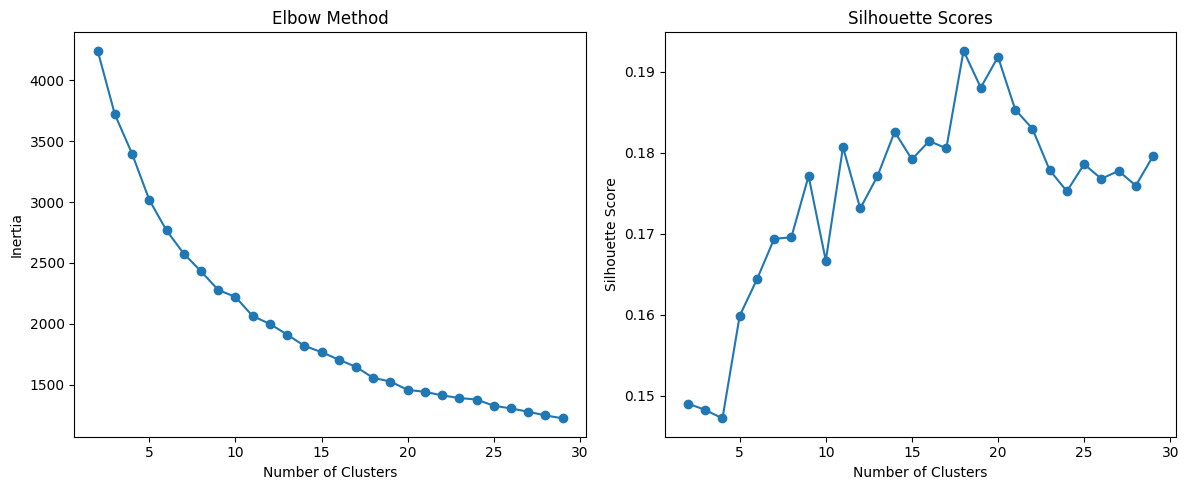

In [4]:
# 2. Determine Optimal Number of Clusters
# ---------------------------------------
# Use the Elbow Method and Silhouette Score
inertia = []
silhouette = []
cluster_range = range(2, 30)  # testing cluster sizes from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(df_scaled, labels)
    silhouette.append(silhouette_avg)

# Plot the Elbow Method and Silhouette Score side-by-side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()

In [5]:
# From the plots, assume the optimal number of clusters is 13
optimal_clusters = 26

In [6]:
# 3. Apply K-Means Clustering
# ---------------------------
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

In [7]:
# 4. Summarize Cluster Characteristics
# --------------------------------------
# Calculate average values for Pollution, CO2, and Temp for each cluster
cluster_summary = df.groupby('Cluster')[['Pollution', 'CO2', 'Temp']].mean().reset_index()
print("Cluster Summary (Average Values):")
print(cluster_summary)

Cluster Summary (Average Values):
    Cluster   Pollution         CO2       Temp
0         0  121.666667  356.333333  17.280422
1         1  390.047619  363.261905  34.591448
2         2  364.080000  464.720000  16.718418
3         3  194.457143  458.800000  18.127881
4         4  109.292683  343.195122  16.760140
5         5   95.370370  339.851852  34.232653
6         6  129.187500  449.468750  34.480656
7         7  323.230769  463.487179  32.673059
8         8  404.976744  426.697674  17.738769
9         9  381.512821  346.769231  29.322389
10       10  375.104167  456.208333  26.189122
11       11  384.522727  369.181818  29.757735
12       12   94.766667  404.066667  20.886365
13       13   83.968750  447.812500  30.039148
14       14  389.800000  334.571429  16.544851
15       15  126.000000  428.868421  32.111745
16       16  328.279070  442.930233  17.910015
17       17  174.029412  453.911765  17.554115
18       18  160.369565  415.434783  16.566383
19       19   87.547619  4

In [8]:
# 5. Label Clusters Based on Pollution Severity
# ----------------------------------------------
# For simplicity, sort clusters by average Pollution level and assign labels accordingly
sorted_clusters = cluster_summary.sort_values('Pollution')['Cluster'].values
severity_labels = {sorted_clusters[0]: 'Low Pollution',
                   sorted_clusters[1]: 'Moderate Pollution',
                   sorted_clusters[2]: 'High Pollution'}

# Map the labels to the main DataFrame
df['Pollution_Severity'] = df['Cluster'].map(severity_labels)

# Create a new dataset with City, Cluster, and Pollution_Severity (remove duplicates if cities appear multiple times)
new_dataset = df[['City', 'Cluster', 'Pollution_Severity']].drop_duplicates().reset_index(drop=True)
print("\nNew Dataset with Cluster Assignments and Pollution Severity:")
print(new_dataset.head())


New Dataset with Cluster Assignments and Pollution Severity:
           City  Cluster Pollution_Severity
0         Maine        1                NaN
1          Iowa        6                NaN
2      Maryland        7                NaN
3  North Dakota       16                NaN
4      Maryland       18                NaN


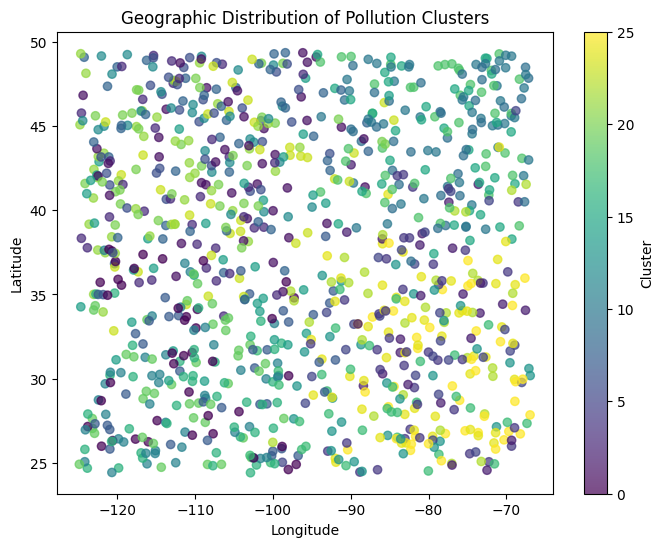

In [9]:
# 6. Visualize the Clusters
# -------------------------
# (a) Scatter plot of Longitude vs. Latitude colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Pollution Clusters')
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
plt.show()

/tmp/ipykernel_147599/155453046.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Pollution Severity')


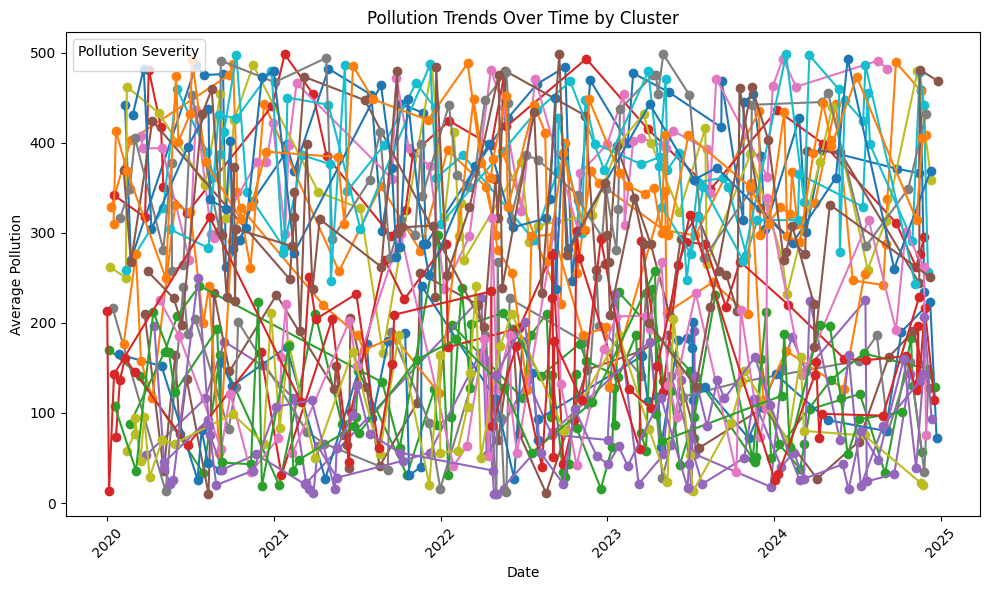

In [10]:
# (b) Pollution trends over time by cluster
# Group data by Date and Cluster to compute the average Pollution per day per cluster
pollution_trend = df.groupby(['Date', 'Cluster'])['Pollution'].mean().reset_index()

plt.figure(figsize=(10, 6))
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = pollution_trend[pollution_trend['Cluster'] == cluster]
    plt.plot(cluster_data['Date'], cluster_data['Pollution'], marker='o')
plt.xlabel('Date')
plt.ylabel('Average Pollution')
plt.title('Pollution Trends Over Time by Cluster')
plt.legend(title='Pollution Severity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# --- Data Preparation ---
# Ensure that the Date column is in datetime format and sort data by City and Date.
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['City', 'Date'])

In [11]:
# Calculate Temperature Change per city.
# Here, for a given record (year t), we define:
#    Temp_Change = (Average temperature for years t-3, t-2, t-1) - (Temperature for year t-4)
# We compute the rolling average with a window of 3 and shift by 1 so that the current year is not included.
df['temp_rolling'] = df.groupby('City')['Temp'].transform(lambda x: x.rolling(window=3).mean().shift(1))
df['temp_prev'] = df.groupby('City')['Temp'].shift(4)
df['Temp_Change'] = df['temp_rolling'] - df['temp_prev']

In [12]:
# --- Correlation Analysis ---
# 1. Temperature vs. Latitude
mask_temp_lat = df[['Temp', 'Latitude']].dropna()
corr_temp_lat, p_val_temp_lat = pearsonr(mask_temp_lat['Temp'], mask_temp_lat['Latitude'])

In [13]:
# 2. Temperature vs. Pollution
mask_temp_poll = df[['Temp', 'Pollution']].dropna()
corr_temp_poll, p_val_temp_poll = pearsonr(mask_temp_poll['Temp'], mask_temp_poll['Pollution'])

In [14]:
# 3. Temperature Change vs. Pollution
mask_temp_change_poll = df[['Temp_Change', 'Pollution']].dropna()
corr_temp_change_poll, p_val_temp_change_poll = pearsonr(mask_temp_change_poll['Temp_Change'], mask_temp_change_poll['Pollution'])

In [15]:
# Create a summary table with correlation coefficients and p-values.
results = pd.DataFrame({
    'Variable Pair': ['Temp vs. Latitude', 'Temp vs. Pollution', 'Temp_Change vs. Pollution'],
    'Pearson Correlation': [corr_temp_lat, corr_temp_poll, corr_temp_change_poll],
    'p-value': [p_val_temp_lat, p_val_temp_poll, p_val_temp_change_poll]
})

print("Correlation Analysis Results:")
print(results)

Correlation Analysis Results:
               Variable Pair  Pearson Correlation   p-value
0          Temp vs. Latitude             0.007673  0.808526
1         Temp vs. Pollution             0.031994  0.312137
2  Temp_Change vs. Pollution             0.046413  0.189717


In [16]:
# --- Visualization ---
# Define a function to generate scatter plots with regression lines.
def scatter_with_regression(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, alpha=0.7)
    # Compute the regression line parameters.
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = intercept + slope * x_line
    plt.plot(x_line, y_line, color='red', label=f'Regression line (r = {r_value:.2f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

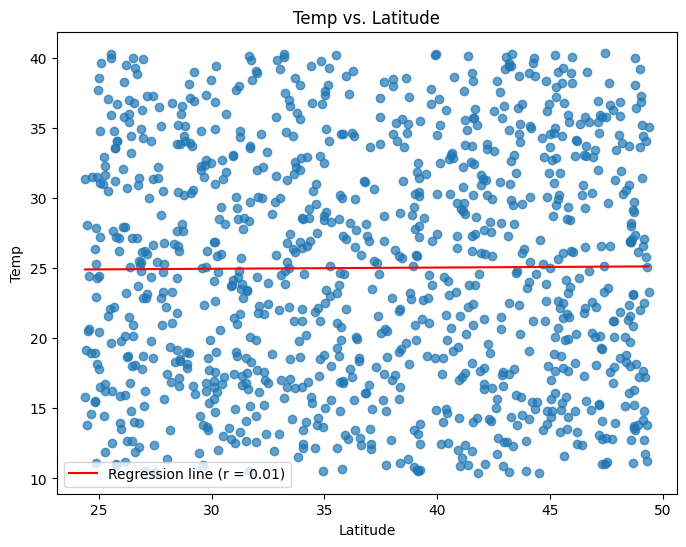

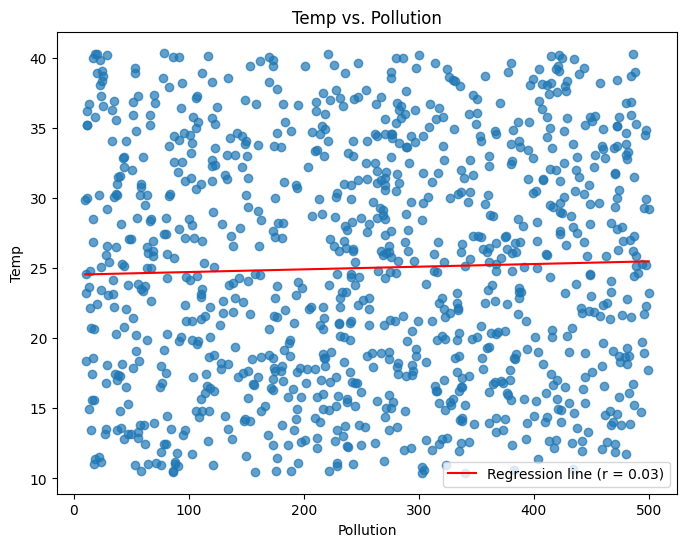

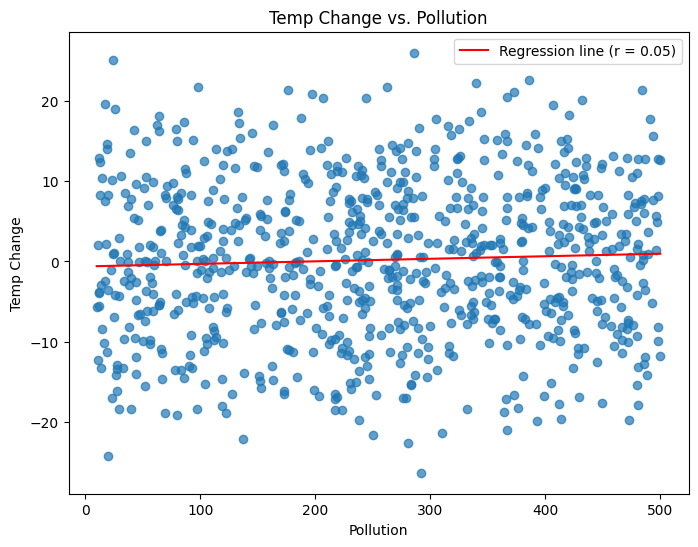

In [17]:
# Plot 1: Temperature vs. Latitude
scatter_with_regression(
    x=mask_temp_lat['Latitude'],
    y=mask_temp_lat['Temp'],
    xlabel='Latitude',
    ylabel='Temp',
    title='Temp vs. Latitude'
)

# Plot 2: Temperature vs. Pollution
scatter_with_regression(
    x=mask_temp_poll['Pollution'],
    y=mask_temp_poll['Temp'],
    xlabel='Pollution',
    ylabel='Temp',
    title='Temp vs. Pollution'
)

# Plot 3: Temperature Change vs. Pollution
scatter_with_regression(
    x=mask_temp_change_poll['Pollution'],
    y=mask_temp_change_poll['Temp_Change'],
    xlabel='Pollution',
    ylabel='Temp Change',
    title='Temp Change vs. Pollution'
)

## SECTION 2: Correlation Analysis

##SECTION 3: ARIMA model for temperature forecasting

In [ ]:
# Although we can determine p, q values manually by looking at the ACF and PACF plots for a given city, we must automate the process
#(OPTIONAL) To automate the process, we must perform a grid search over different values of p and q and choose the ARIMA model for which the AIC and BIC values are minimum

p_range = q_range = list(range(0,#))  # taking values from 0 to # (decide this looking at PACF)

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(city_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

In [ ]:
# fitting an ARIMA model with chosen p, d, q values and calculating the mean squared error
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)



## Conclusion

write here the report for the project